Why exactly is it helpful for an algorithm to be able to classify high-z sources from their spectra?
Ultimately science goal to use high-z to constrain cosmological parameters. How accurately we can constrain depends on . The better we can measure Ly-a the better the cosmological parameters. Increasing data volume. Finding high-z in an automated way, for HETDEX goals. 


# Questions 04/03/23:

    * Now that it's trained (after visually inspecting), how do I make this useful to other people?
    
        *write up about what I did/found helpful. difference in samples.
        
        * make sure most useful. have it runnable in an easy. setting up in a super user friendly. lots of write ups. future student. 
    
    * so what is the spec_err?
    

## Notes:
    * Get x and y for spectra plots
        - X axis should be wavelength in Angstroms and then the y-axis should be flux density a unit called f_Lambda and i believe the units ofr that are 10^-17 erg/s/cm^2/Angstrom

## Things to do:

    * Figure out important questions/notes for presentation
    
    * Visually inspect everything
    
## Presentation

    - They are interesting sources
    - Lyman Alpha cna be used to retrace reionzation, periond of unknown universe time. Can use lyman alpha to retrace back in time.
    - High redshift cause that is when reionization occurs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # statistical data visualization

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

In [2]:
# Using this to be able to plot spectra. For some reason Jupyter won't let me plot spectra without this
%matplotlib inline

In [3]:
# loading in the decoded sources I got from inputting random encoded sources into t-sne.
# These will be our testing sample
random_highz_sources = np.load("highz_sources.npy")

In [4]:
# loading in my high confidence high z sources.
high_confidence_highz_spectra_sn7 = np.load("high_confidence_highz_sn7_10000.npy", allow_pickle = True)
high_confidence_highz_spec_err_sn7 = np.load("high_confidence_highz_spec_err_sn7_10000.npy", allow_pickle = True)

In [5]:
# This code below takes my high-confidence high redshift sample and divides it by the high-confidence error. 
# Basically reduces the noisy parts and keeps the peaks (not perfect but really well).
# Returns the de-noised spectra into an array called 'high_confidence_over_specc_err'
num_sources = high_confidence_highz_spectra_sn7.shape[0]
confidence_over_spec_err_LS = [[0] * 1 for i in range(num_sources)]

counter = 0

while counter < num_sources:
    confidence_over_spec_err_LS[counter] = \
    high_confidence_highz_spectra_sn7[counter] / high_confidence_highz_spec_err_sn7[counter]
    
    counter += 1

high_confidence_over_specc_err = np.array(confidence_over_spec_err_LS)

In [6]:
# loading in the noise sample.
noise_sample = np.load("noise_sample_10000.npy", allow_pickle = True)

In [7]:
# combining my high-confidence spectra with my noise spectra into one large array
twodspectra = np.concatenate((high_confidence_over_specc_err, noise_sample))

In [8]:
# basically creating labels for my classification, a '1' is a high_z source and a '0' is a noise source
highz_classification = np.ones(10000)
noise_classification = np.zeros(10000)

merge_classification = np.append(highz_classification, noise_classification)

In [9]:
# setting my x and y to input into my ML algorithm
X = twodspectra
y = merge_classification

In [10]:
# Splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [11]:
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier

In [12]:
# creating a RF classifier
rfc = RandomForestClassifier(n_estimators = 700, random_state = 42)  

In [13]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=700, random_state=42)

In [14]:
# performing predictions on the test dataset
y_pred = rfc.predict(X_test)

In [15]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.9855
Precision: 0.9819078947368421
Recall: 0.9893934371892609


In [18]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred, normalize = 'true').ravel()

In [23]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()

In [24]:
(tn, fp, fn, tp)

(2928, 55, 32, 2985)

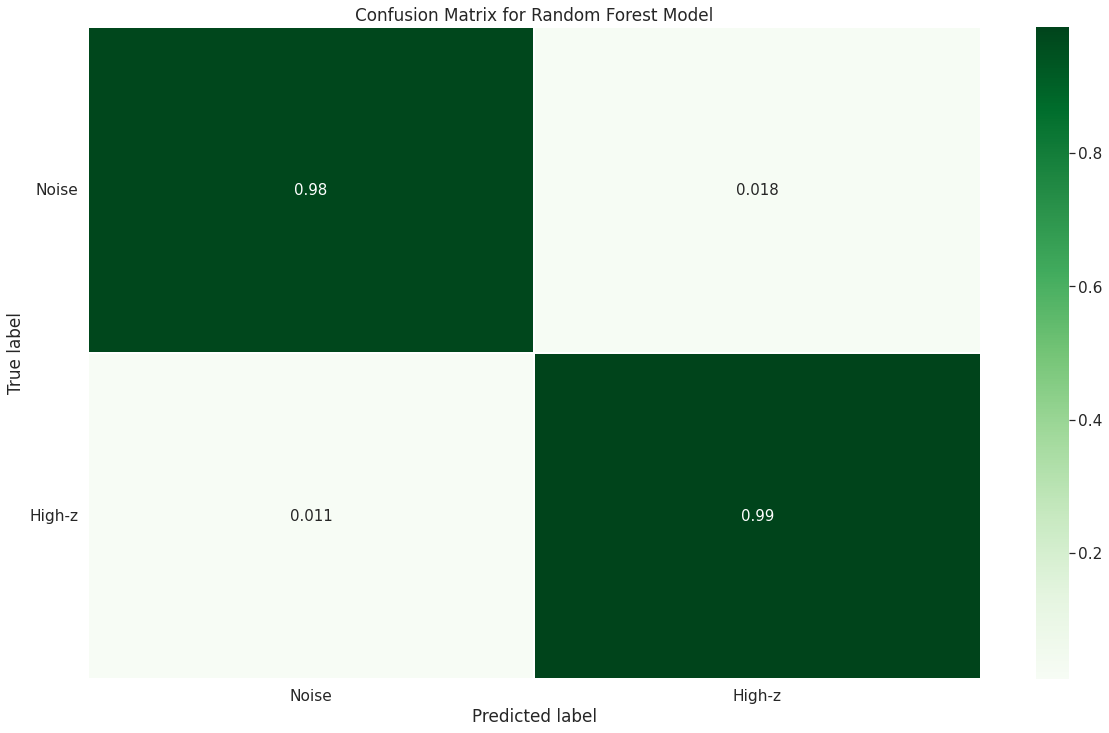

In [20]:
# Get and reshape confusion matrix data
matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(20,12))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Noise', 'High-z']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names, rotation= 0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

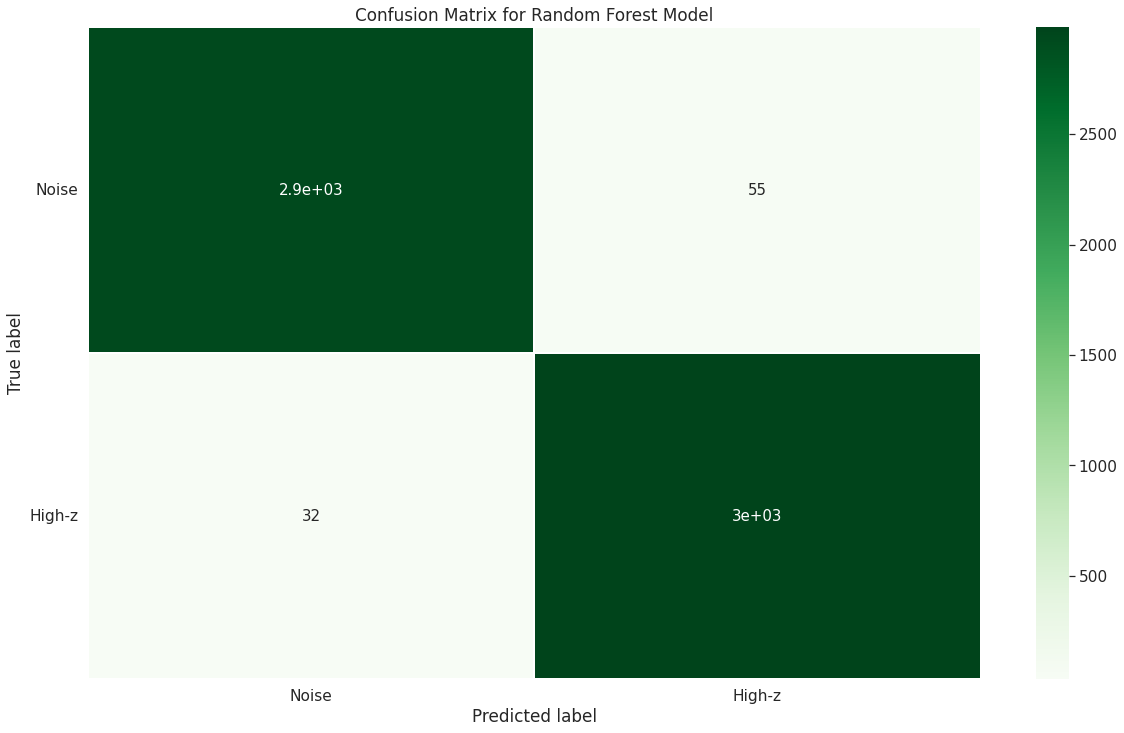

In [27]:
# Get and reshape confusion matrix data
matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float')
#matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(20,12))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Noise', 'High-z']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names, rotation= 0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

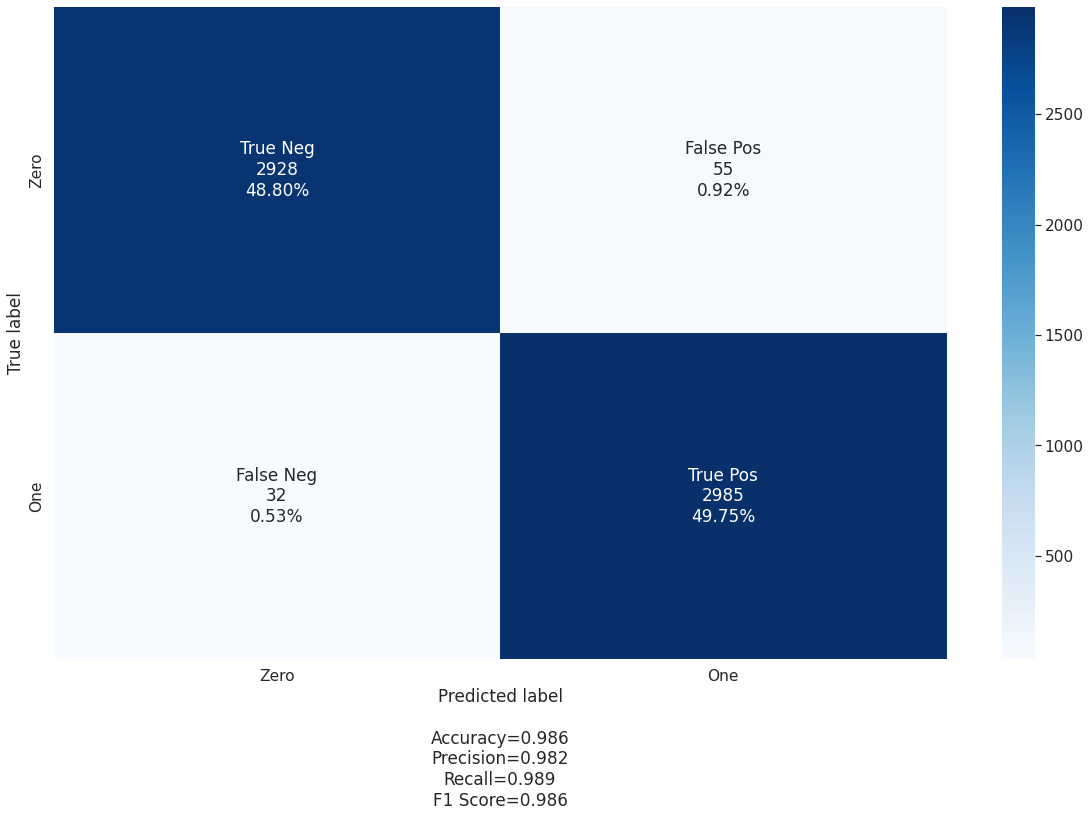

In [39]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
## function I got from google/github
make_confusion_matrix(matrix, 
                      group_names=labels,
                      categories=categories, figsize=(20,12))

In [19]:
false_positive = X_test[(y_test == 0) & (y_pred == 1)]  # predicted high-z but actually noise
false_negative = X_test[(y_test == 1) & (y_pred == 0)]  # predicted noise but actually high-z

true_positive = X_test[(y_test == 1) & (y_pred == 1)] # predicted high-z and actually is high-z
true_negative = X_test[(y_test == 0) & (y_pred == 0)] # predicted noise and actually is noise

In [20]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [21]:
# false_negative = predicted noise but actually high-z
# reminder: high_confidence_over_specc_err = high_confidence_highz_spectra_sn7 / high_confidence_highz_spec_err_sn7
def false_neg_check(n):
    # getting the index of where this false_neg is in the original array
    idx = np.where(high_confidence_over_specc_err == false_negative[n])[0][0]
    y = false_negative[n]
    y2 = high_confidence_highz_spectra_sn7[idx]
    y3 = high_confidence_highz_spec_err_sn7[idx]
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize=(16, 4));
    fig.suptitle("False negatives (predicted noise but actually high-z)", y = 1.05)
    ax1.plot(y)
    ax1.title.set_text("high-z/spec_err")
    ax2.plot(y2)
    ax2.title.set_text("high-z")
    ax3.plot(y3)
    ax3.title.set_text("spec_err")
    plt.show()
    
widgets.interact(false_neg_check, n=(0, false_negative.shape[0] - 1));

interactive(children=(IntSlider(value=15, description='n', max=31), Output()), _dom_classes=('widget-interact'…

In [ ]:
# false_positive =  predicted high-z but actually noise
# for the noise, we never divided spec_err, so nothing to compare to, as in, with the high-z we can compare a
# before diving by spec_err and after
def false_pos_check(n):
    y = false_positive[n]
    fig, ax = plt.subplots(nrows = 1, ncols = 1);
    fig.suptitle("False positives (predicted high-z but actually noise)", y = 1.05)
    ax.plot(y)
    plt.show()
    
widgets.interact(false_pos_check, n=(0, false_positive.shape[0] - 1));

In [ ]:
# true_negative = predicted noise and actually is noise
def true_neg_check(n):
    y = true_negative[n]
    fig, ax = plt.subplots(nrows = 1, ncols = 1);
    fig.suptitle("True negative (predicted noise and actually is noise)", y = 1.05)
    ax.plot(y)
    plt.show()
    
widgets.interact(true_neg_check, n=(0, true_negative.shape[0] - 1));

In [51]:
# true_positive = predicted high-z and actually is high-z
# reminder: high_confidence_over_specc_err = high_confidence_highz_spectra_sn7 / high_confidence_highz_spec_err_sn7
def true_pos_check(n):
    # getting the index of where this false_neg is in the original array
    idx = np.where(high_confidence_over_specc_err == true_positive[n])[0][0]
    y = true_positive[n]
    y2 = high_confidence_highz_spectra_sn7[idx]
    y3 = high_confidence_highz_spec_err_sn7[idx]
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize=(16, 4));
    fig.suptitle("True positive (predicted high-z and actually is high-z)", y = 1.05)
    ax1.plot(y)
    ax1.title.set_text("high-z/spec_err")
    ax2.plot(y2)
    ax2.title.set_text("high-z")
    ax3.plot(y3)
    ax3.title.set_text("spec_err")
    plt.show()
    
widgets.interact(true_pos_check, n=(0, true_positive.shape[0] - 1));

interactive(children=(IntSlider(value=1492, description='n', max=2984), Output()), _dom_classes=('widget-inter…

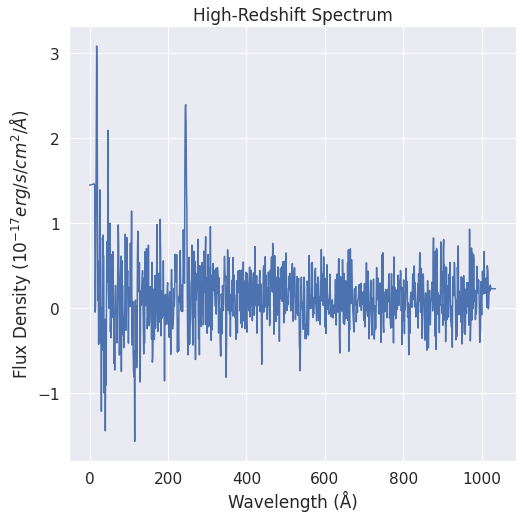

In [84]:
x_size = 8
y_size = 8
plt.figure(figsize=(x_size, y_size))
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux Density ($10^{-17} erg/s/cm^2/Å$)")
plt.title("High-Redshift Spectrum")
plt.plot(high_confidence_highz_spectra_sn7[31])
# plt.subplots_adjust(bottom = 0.20) # this is so the bottom doesn't cut off
#plt.savefig(f'Poster-plots/good_highz-{x_size}-{y_size}.png')

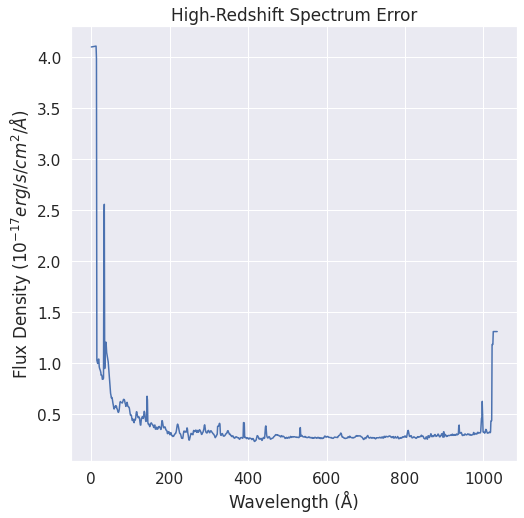

In [87]:
x_size = 8
y_size = 8
plt.figure(figsize=(x_size, y_size))
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux Density ($10^{-17} erg/s/cm^2/Å$)")
plt.title("High-Redshift Spectrum Error")
plt.plot(high_confidence_highz_spec_err_sn7[31])
# plt.subplots_adjust(bottom = 0.20) # this is so the bottom doesn't cut off
#plt.savefig(f'Poster-plots/good_highz-{x_size}-{y_size}.png')

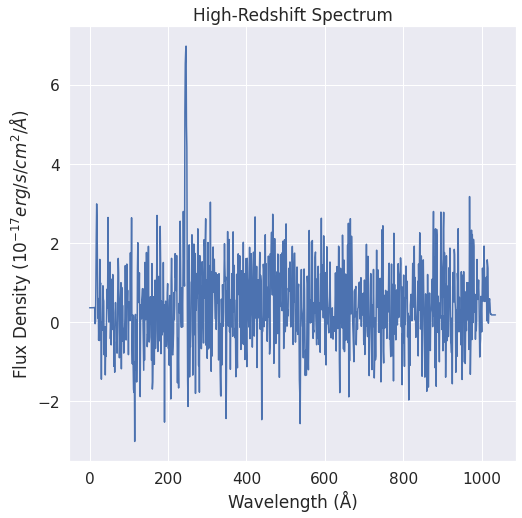

In [86]:
x_size = 8
y_size = 8
plt.figure(figsize=(x_size, y_size))
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux Density ($10^{-17} erg/s/cm^2/Å$)")
plt.title("High-Redshift Spectrum")
plt.plot(high_confidence_over_specc_err[31])
# plt.subplots_adjust(bottom = 0.20) # this is so the bottom doesn't cut off
#plt.savefig(f'Poster-plots/good_highz-{x_size}-{y_size}.png')

In [ ]:
def random_highz(n):
    y = high_confidence_highz_spectra_sn7[n]
    fig, ax = plt.subplots(nrows = 1, ncols = 1);
    fig.suptitle("High-z", y = 1.05)
    ax.plot(y)
    plt.show()
    
widgets.interact(random_highz, n=(0, high_confidence_highz_spectra_sn7.shape[0] - 1));

In [ ]:
x_size = 10
y_size = 8
plt.figure(figsize=(x_size, y_size))
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux Density ($10^{-17} erg/s/cm^2/Å$)")
plt.title("High-Redshift Spectrum")
plt.plot(high_confidence_highz_spectra_sn7[7])
# plt.subplots_adjust(bottom = 0.20) # this is so the bottom doesn't cut off
#plt.savefig(f'Poster-plots/good_highz-{x_size}-{y_size}.png')

In [ ]:
x_size = 10
y_size = 8
plt.figure(figsize=(x_size, y_size))
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux Density ($10^{-17} erg/s/cm^2/Å$)")
plt.title("Noise Spectrum")
plt.plot(noise_sample[26])
# plt.subplots_adjust(bottom = 0.20) # this is so the bottom doesn't cut off
#plt.savefig(f'Poster-plots/good_noise-{x_size}-{y_size}.png')

In [ ]:
def random_noise(n):
    y = noise_sample[n]
    fig, ax = plt.subplots(nrows = 1, ncols = 1);
    fig.suptitle("noise", y = 1.05)
    ax.plot(y)
    plt.show()
    
widgets.interact(random_noise, n=(0, noise_sample.shape[0] - 1));

# Ideas to try if our confidence stopped going up!

### Data set with sn > 7 and check if there's a difference to give us less false positives
### Warm start
### sklearn standard scaler (OR ANOTHER OPTION)
### cross correlation
### RandomParameterSearch
### Pass in the signal to noise spectrum (spec_err)

In [ ]:
from sklearn import tree
import dtreeviz # will be used for tree visualization

[Text(0.7382952044507655, 0.9848484848484849, 'X[731] <= 0.526\ngini = 0.5\nsamples = 8863\nvalue = [7023, 6977]\nclass = highz'),
 Text(0.5341990476906355, 0.9545454545454546, 'X[648] <= 0.673\ngini = 0.482\nsamples = 6585\nvalue = [6190, 4212]\nclass = highz'),
 Text(0.43766535029007037, 0.9242424242424242, 'X[857] <= 0.689\ngini = 0.436\nsamples = 5509\nvalue = [5901, 2796]\nclass = highz'),
 Text(0.3597934355572969, 0.8939393939393939, 'X[744] <= 0.766\ngini = 0.376\nsamples = 4792\nvalue = [5654, 1894]\nclass = highz'),
 Text(0.28411621928185926, 0.8636363636363636, 'X[875] <= 0.774\ngini = 0.312\nsamples = 4335\nvalue = [5499, 1318]\nclass = highz'),
 Text(0.22348302273698253, 0.8333333333333334, 'X[849] <= 0.931\ngini = 0.257\nsamples = 4017\nvalue = [5364, 957]\nclass = highz'),
 Text(0.1652724661484672, 0.803030303030303, 'X[583] <= 0.668\ngini = 0.22\nsamples = 3876\nvalue = [5335, 767]\nclass = highz'),
 Text(0.08822637476894639, 0.7727272727272727, 'X[857] <= -0.73\ngini = 

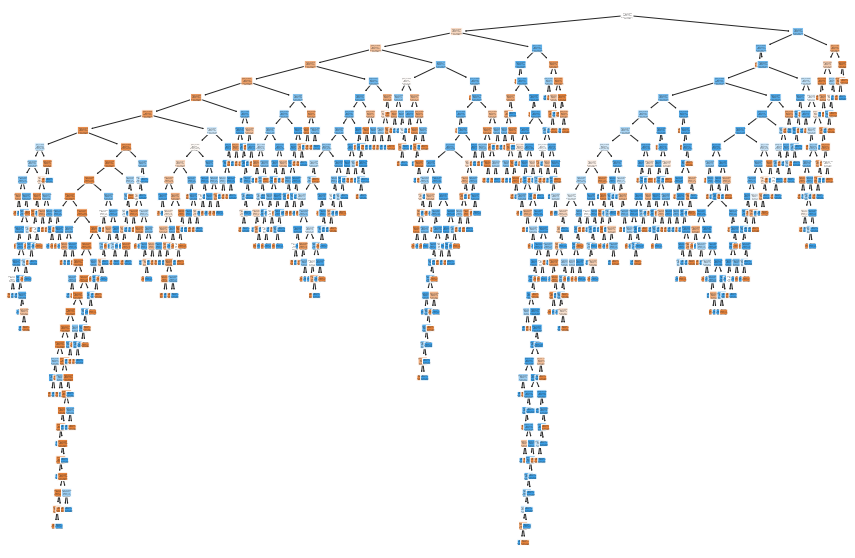

In [34]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(rfc.estimators_[99],
          class_names=["highz", "noise"], 
          filled=True, impurity=True, 
          rounded=True)

[Text(0.5, 0.875, 'X[731] <= 0.526\ngini = 0.5\nsamples = 8863\nvalue = [7023, 6977]\nclass = highz'),
 Text(0.25, 0.625, 'X[648] <= 0.673\ngini = 0.482\nsamples = 6585\nvalue = [6190, 4212]\nclass = highz'),
 Text(0.125, 0.375, 'X[857] <= 0.689\ngini = 0.436\nsamples = 5509\nvalue = [5901, 2796]\nclass = highz'),
 Text(0.0625, 0.125, 'gini = 0.376\nsamples = 4792\nvalue = [5654, 1894]\nclass = highz'),
 Text(0.1875, 0.125, 'gini = 0.338\nsamples = 717\nvalue = [247, 902]\nclass = noise'),
 Text(0.375, 0.375, 'X[102] <= 3.782\ngini = 0.282\nsamples = 1076\nvalue = [289, 1416]\nclass = noise'),
 Text(0.3125, 0.125, 'gini = 0.26\nsamples = 1054\nvalue = [256, 1414]\nclass = noise'),
 Text(0.4375, 0.125, 'gini = 0.108\nsamples = 22\nvalue = [33, 2]\nclass = highz'),
 Text(0.75, 0.625, 'X[990] <= 2.626\ngini = 0.356\nsamples = 2278\nvalue = [833, 2765]\nclass = noise'),
 Text(0.625, 0.375, 'X[11] <= 0.544\ngini = 0.321\nsamples = 2149\nvalue = [682, 2717]\nclass = noise'),
 Text(0.5625, 0.

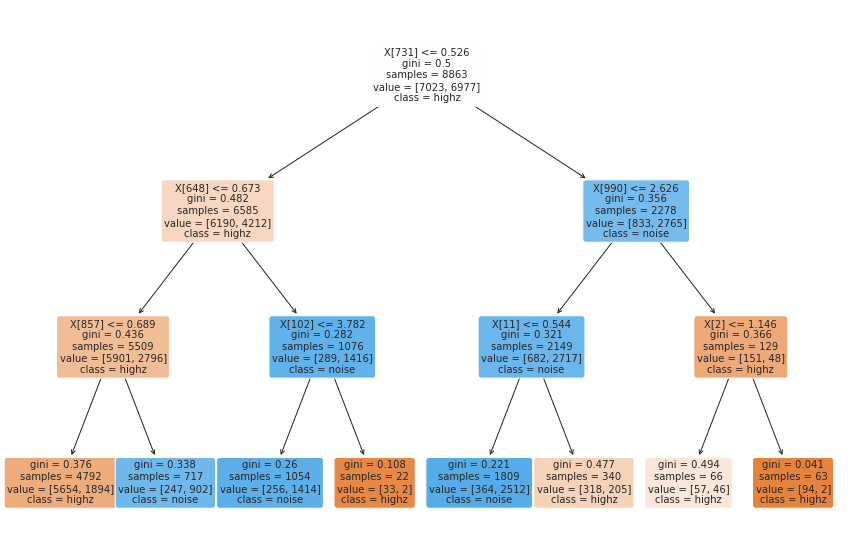

In [44]:
rfc_plot = RandomForestClassifier(n_estimators = 700, max_depth = 3, random_state = 42)
rfc_plot.fit(X_train, y_train)

from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(rfc_plot.estimators_[99],
          class_names=["highz", "noise"], 
          filled=True, impurity=True, 
          rounded=True, fontsize = 10)

In [89]:
import dtreeviz

In [91]:
import dtreeviz.trees

In [98]:
viz = dtreeviz.model(rfc.estimators_[99], X, y,
               target_name="high-z",
               class_names=["highz", "noise"])

viz.view()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

In [ ]:
plt.plot(X[42])

In [ ]:
plt.plot(X[984])

## Plotting
https://garg-mohit851.medium.com/random-forest-visualization-3f76cdf6456f 

https://builtin.com/data-science/random-forest-python-deep-dive

https://vitalflux.com/random-forest-classifier-python-code-example/

https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/